In [40]:
import finesse.virgo
from finesse.analysis.actions import FrequencyResponse, Xaxis

import numpy as np
import matplotlib.pyplot as plt

import time

finesse.init_plotting()

In [18]:
# prepare a pretuned Virgo model
# this is an old model that was tuned using zero_k00=True
virgo = finesse.virgo.Virgo('virgoKat_tuned.kat', zero_k00=True)

virgo.model.parse('''
# adding detectors needed for this kat file.
pd1 B4_112 B4_attenuator.p3.o f=2*eom56.f
mathd B4_112_mag abs(B4_112)

# add a new dof for the DARM tf
dof DARM_Fz NE.dofs.F_z -1 WE.dofs.F_z +1
''')

# make but do not switch to dc lock
virgo.make(dc_lock=False)

Adjusting recycling cavity lengths...
Pretuning...
Optimizing demodulation phases...
Optimizing lock gains...
Running RF locks...
Done.


In [19]:
def get_DARM(base, dof='DARM_Fz', readout_port='B1p_56.I', axis=[0.5, 1000, 201]):
    model = base.deepcopy()
    
    model.parse('fsig(1)')

    return model.run(FrequencyResponse(
        np.geomspace(*axis),
        [dof],
        [readout_port]
    ))

def get_DARM2(base, dof='DARM_Fz', readout_port='B1p_56.I', axis=[0.5, 1000, 201]):
    model = base.deepcopy()
    
    model.parse('fsig(1)')

    model.eom6.order = 0
    model.eom8.order = 0

    return model.run(FrequencyResponse(
        np.geomspace(*axis),
        [dof],
        [readout_port]
    ))

def get_DARM2_sgen(base, axis=[0.5, 1000, 200]):

    model = base.deepcopy()

    model.eom6.order = 0
    model.eom8.order = 0

    model.parse("""
    fsig(1)

    # apply a signal to the end mirrors
    sgen sigQ NE.mech.F_z phase=180
    sgen sigI WE.mech.F_z

    # read the output after the SRC
    pd2 darm SRAR.p2.o f1=eom56.f phase1=B1p_56.phase f2=fsig.f phase2=none
    """
    )

    return model.run(Xaxis(model.fsig.f, "log", *axis))

In [35]:
maxtems = [2,4,6,8,10]

runs = []

for maxtem in maxtems:
    # display current step
    print(maxtem)

    times = []

    # set the maxtem
    virgo.model.modes(maxtem=maxtem)

    # time all the things
    start_time = time.time()
    sgen = virgo.get_DARM()
    end_time = time.time() - start_time
    print('old', end_time, 's')
    times.append(end_time)

    start_time = time.time()
    sgen_nomod = get_DARM2_sgen(virgo.model)
    end_time = time.time() - start_time
    print('sgen RF off', end_time, 's')
    times.append(end_time)

    start_time = time.time()
    fr = get_DARM(virgo.model)
    end_time = time.time() - start_time
    print('FR', end_time, 's')
    times.append(end_time)

    start_time = time.time()
    nomod = get_DARM2(virgo.model)
    end_time = time.time() - start_time
    print('FR RF off', end_time, 's')
    times.append(end_time)

    runs.append(times)

print(runs)


2
old 2.2615699768066406 s
sgen RF off 2.303090810775757 s
FR 1.7049145698547363 s
FR RF off 0.9537625312805176 s
4
old 23.968078136444092 s
sgen RF off 4.912276268005371 s
FR 21.968186616897583 s
FR RF off 4.030262470245361 s
6
old 120.43478512763977 s
sgen RF off 43.449617862701416 s
FR 102.86878800392151 s
FR RF off 38.25415062904358 s
8
old 140.97398447990417 s
sgen RF off 161.44725465774536 s
FR 112.70761466026306 s
FR RF off 145.82902121543884 s
10
old 398.8895614147186 s
sgen RF off 521.9037268161774 s
FR 315.5718150138855 s
FR RF off 484.201810836792 s
[[2.2615699768066406, 2.303090810775757, 1.7049145698547363, 0.9537625312805176], [23.968078136444092, 4.912276268005371, 21.968186616897583, 4.030262470245361], [120.43478512763977, 43.449617862701416, 102.86878800392151, 38.25415062904358], [140.97398447990417, 161.44725465774536, 112.70761466026306, 145.82902121543884], [398.8895614147186, 521.9037268161774, 315.5718150138855, 484.201810836792]]


Text(0.5, 0, 'maxtem')

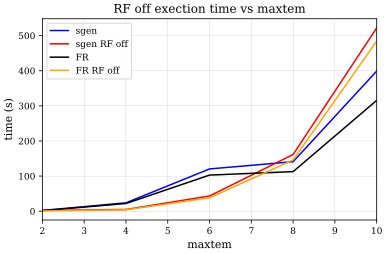

In [41]:
plot = plt.plot(maxtems, runs)
plt.legend(iter(plot), ('sgen', 'sgen RF off', 'FR', 'FR RF off'))
plt.title('RF off exection time vs maxtem')
plt.ylabel('time (s)')
plt.xlabel('maxtem')